In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score

import time
import os
import session_info

from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz

from subprocess import call, check_call
from IPython.display import Image
import pydot
from sklearn import tree

In [2]:
# pandas settings

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# session module version

session_info.show()

## Importing Dataset

In [4]:
# changing directory to main with chdir

os.getcwd()
os.chdir('../../')

In [5]:
path = os.getcwd()
path = path+'/stage-2/second-iteration/output/data.csv'

In [6]:
# reading data

data = pd.read_csv(path)

In [7]:
data.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,previous,contact_cellular,contact_telephone,marital_divorced,marital_married,marital_single,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,y
0,0.662810,-0.259196,0,-0.445083,1,0,0.662810,-0.439695,-0.279218,-0.898687,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.665224,-0.259196,0,-0.454841,1,1,-0.665224,-0.439695,-1.016949,-0.898687,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.025001,-0.259196,0,0.088693,1,0,1.025001,-0.439695,-0.859567,-0.898687,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,-0.665224,-0.259196,0,-0.455202,0,0,-0.665224,-0.439695,0.183093,-0.898687,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,-0.423764,1.306414,0,-0.372082,1,0,-0.423764,-0.439695,-0.397255,-0.898687,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


## Modelling

### Split Data Train & Test

#### 80 : 20

In [8]:
# categorising feature & label

feature = ['age','education','default','balance','housing','loan','day','month','duration','campaign','previous',
          'contact_cellular','contact_telephone','marital_divorced','marital_married','marital_single',
          'job_admin.','job_blue-collar','job_entrepreneur','job_housemaid','job_management','job_retired','job_self-employed',
          'job_services','job_student','job_technician','job_unemployed']

label   = ['y']

In [9]:
X = data[feature]
y = data['y']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=89)

### Modeling Preparation

#### Evaluation Method

In [11]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [12]:
def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [13]:
def draw_learning_curve_tree(param_values):
    train_scores = []
    test_scores = []

    for n in param_values:
        model = DecisionTreeClassifier(min_samples_split=10,criterion='gini',splitter='best',max_depth=n)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(n) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter n-neighbor - KNN')
    plt.legend()
    plt.show()

In [14]:
def draw_learning_curve_forest(param_values):
    train_scores = []
    test_scores = []

    for n in param_values:
        model = RandomForestClassifier(criterion='gini',max_depth=None, n_estimators=n)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(n) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter n-neighbor - KNN')
    plt.legend()
    plt.show()

### Decision Tree

#### Without Hyperparameter Tuning

In [15]:
start_time = time.time()

tree = DecisionTreeClassifier(max_depth=None,
                                min_samples_split=2,
                                criterion='gini',
                                splitter='best')
tree.fit(X_train, y_train)

print("\nExecution time: " + str((time.time() - start_time)) + ' ms')


Execution time: 0.3011009693145752 ms


In [16]:
ytrain_tree_pred = tree.predict(X_train)
ytest_tree_pred  = tree.predict(X_test)

In [17]:
accuracy_tree_train = accuracy_score(y_train, ytrain_tree_pred)
accuracy_tree_test  = accuracy_score(y_test, ytest_tree_pred)
print("Accuracy  (Train Set)    : %.2f" % accuracy_tree_train)
print("Accuracy  (Test Set)     : %.2f" % accuracy_tree_test)

Accuracy  (Train Set)    : 1.00
Accuracy  (Test Set)     : 0.93


In [18]:
precision_tree_train = precision_score(y_train, ytrain_tree_pred)
precision_tree_test  = precision_score(y_test, ytest_tree_pred)
print("Precision  (Train Set)    : %.2f" % precision_tree_train)
print("Precision  (Test Set)     : %.2f" % precision_tree_test)

Precision  (Train Set)    : 1.00
Precision  (Test Set)     : 0.92


In [19]:
recall_tree_train = recall_score(y_train, ytrain_tree_pred)
recall_tree_test  = recall_score(y_test, ytest_tree_pred)
print("Recall  (Train Set)    : %.2f" % recall_tree_train)
print("Recall  (Test Set)     : %.2f" % recall_tree_test)

Recall  (Train Set)    : 1.00
Recall  (Test Set)     : 0.94


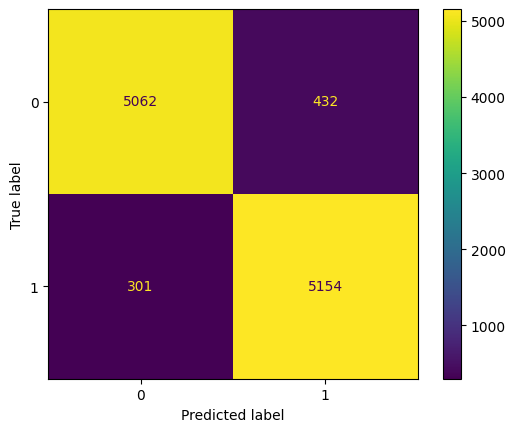

In [20]:
# test prediction confusion matrix

cm = confusion_matrix(y_test, ytest_tree_pred, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()
plt.show()

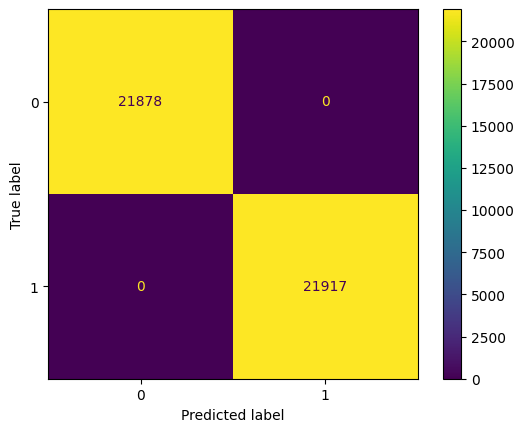

In [21]:
# train prediction confusion matrix

cm = confusion_matrix(y_train, ytrain_tree_pred, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()
plt.show()

#### With Hyperparameter Tuning

In [22]:
max_depth = [None, 5, 10, 20]
min_samples_split= [2, 5, 10]
param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split)

In [23]:
start_time = time.time()

tree = DecisionTreeClassifier(criterion='gini',
                                splitter='best')
tree_grid = GridSearchCV(tree, param_grid, cv=10)
tree_grid.fit(X_train, y_train)

print("\nExecution time: " + str((time.time() - start_time)) + ' ms')


Execution time: 20.13383913040161 ms


In [24]:
print("\nBest: %f using %s" % (tree_grid.best_score_, tree_grid.best_params_))


Best: 0.929764 using {'max_depth': None, 'min_samples_split': 2}


In [25]:
ytrain_tree_grid_pred = tree_grid.predict(X_train)
ytest_tree_grid_pred  = tree_grid.predict(X_test)

In [26]:
accuracy_tree_grid_train = accuracy_score(y_train, ytrain_tree_grid_pred)
accuracy_tree_grid_test  = accuracy_score(y_test, ytest_tree_grid_pred)
print("Accuracy  (Train Set)    : %.2f" % accuracy_tree_grid_train)
print("Accuracy  (Test Set)     : %.2f" % accuracy_tree_grid_test)

Accuracy  (Train Set)    : 1.00
Accuracy  (Test Set)     : 0.93


In [27]:
precision_tree_grid_train = precision_score(y_train, ytrain_tree_grid_pred)
precision_tree_grid_test  = precision_score(y_test, ytest_tree_grid_pred)
print("Precision  (Train Set)    : %.2f" % precision_tree_grid_train)
print("Precision  (Test Set)     : %.2f" % precision_tree_grid_test)

Precision  (Train Set)    : 1.00
Precision  (Test Set)     : 0.92


In [28]:
recall_tree_grid_train = recall_score(y_train, ytrain_tree_grid_pred)
recall_tree_grid_test  = recall_score(y_test, ytest_tree_grid_pred)
print("Recall  (Train Set)    : %.2f" % recall_tree_grid_train)
print("Recall  (Test Set)     : %.2f" % recall_tree_grid_test)

Recall  (Train Set)    : 1.00
Recall  (Test Set)     : 0.94


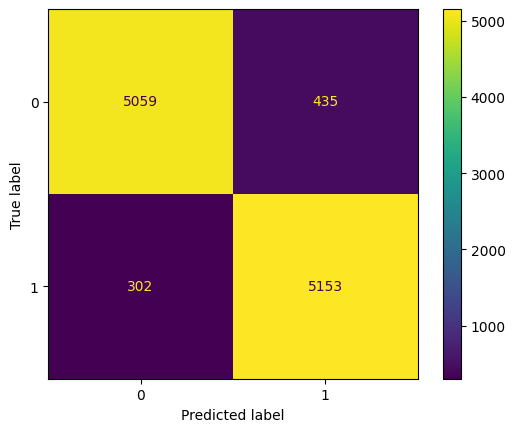

In [29]:
# test prediction confusion matrix

cm = confusion_matrix(y_test, ytest_tree_grid_pred, labels=tree_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_grid.classes_)
disp.plot()
plt.show()

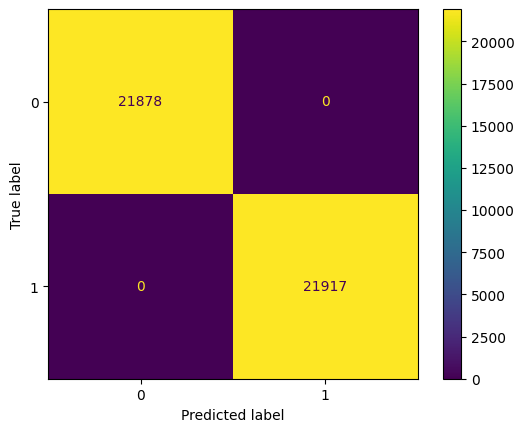

In [30]:
# train prediction confusion matrix

cm = confusion_matrix(y_train, ytrain_tree_grid_pred, labels=tree_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_grid.classes_)
disp.plot()
plt.show()

##### Phase 1 Learning Curve

param value: 1; train: 0.7152669976566388; test: 0.7127412055547974
param value: 11; train: 0.9756714068100162; test: 0.9527052259660318
param value: 21; train: 0.9964911583777143; test: 0.9524715571724441
param value: 32; train: 0.9988100003127006; test: 0.9506424306893246
param value: 42; train: 0.9988897458600459; test: 0.9508617350083101
param value: 53; train: 0.9988843704704261; test: 0.9506352734772406
param value: 63; train: 0.9989013099863085; test: 0.9495613246281168
param value: 74; train: 0.9988797677604782; test: 0.950691229862625
param value: 84; train: 0.9989057531551098; test: 0.9504111643165764
param value: 95; train: 0.9989035581609003; test: 0.9506223771487068
param value: 105; train: 0.9989020378276189; test: 0.9503339531801546
param value: 116; train: 0.9988995717177351; test: 0.9501789303021011
param value: 126; train: 0.9988847104077716; test: 0.9502193543694196
param value: 137; train: 0.9989070628523672; test: 0.9504232264712075
param value: 147; train: 0.99888

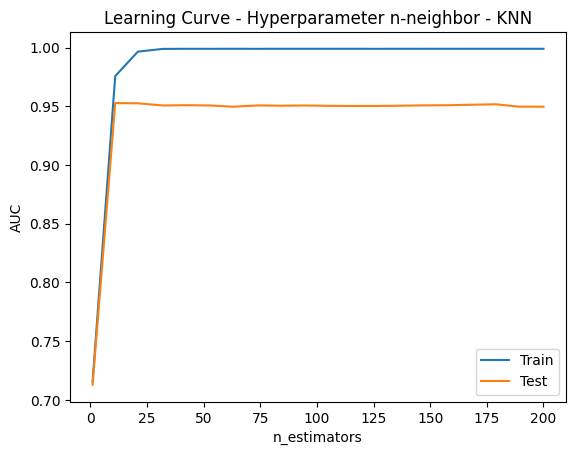

In [31]:
param_values = [int(x) for x in np.linspace(1, 200, 20)]
draw_learning_curve_tree(param_values)

param value: 1; train: 0.7152669976566388; test: 0.7127412055547974
param value: 2; train: 0.794982277022384; test: 0.7914499510673588
param value: 3; train: 0.83316713351604; test: 0.8289830218917262
param value: 4; train: 0.8631321079152334; test: 0.8574410480961314
param value: 6; train: 0.9162362493310378; test: 0.9089171021332496
param value: 7; train: 0.9330473929844181; test: 0.9258052697768451
param value: 8; train: 0.9448442438991143; test: 0.9365446748506913
param value: 9; train: 0.956545555735683; test: 0.9443918655365057
param value: 11; train: 0.9756987321417305; test: 0.9538541670489964
param value: 12; train: 0.9801198790508764; test: 0.9532885971430546
param value: 13; train: 0.9840275839677256; test: 0.9544540882362461
param value: 14; train: 0.987088332902753; test: 0.9541140956370369
param value: 16; train: 0.9909124747550119; test: 0.9528291508409974
param value: 17; train: 0.9923937986619007; test: 0.9531078149748897
param value: 18; train: 0.9938000527240738; tes

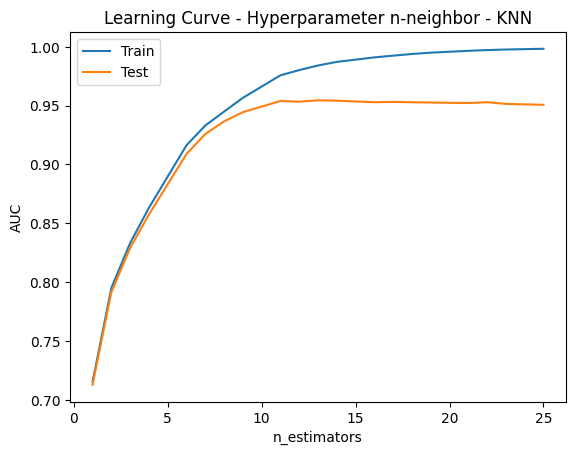

In [32]:
param_values = [int(x) for x in np.linspace(1, 25, 20)]
draw_learning_curve_tree(param_values)

#### Best Result Implementation From Learning Curve

In [33]:
start_time = time.time()

tree_best = DecisionTreeClassifier(max_depth=1,
                              criterion='gini',
                              splitter='best')
tree_best.fit(X_train, y_train)

print("\nExecution time: " + str((time.time() - start_time)) + ' ms')


Execution time: 0.025512218475341797 ms


In [34]:
ytrain_tree_best_pred = tree_best.predict(X_train)
ytest_tree_best_pred  = tree_best.predict(X_test)

In [35]:
accuracy_tree_best_train = accuracy_score(y_train, ytrain_tree_best_pred)
accuracy_tree_best_test  = accuracy_score(y_test, ytest_tree_best_pred)
print("Accuracy  (Train Set)    : %.2f" % accuracy_tree_best_train)
print("Accuracy  (Test Set)     : %.2f" % accuracy_tree_best_test)

Accuracy  (Train Set)    : 0.72
Accuracy  (Test Set)     : 0.71


In [36]:
precision_tree_best_train = precision_score(y_train, ytrain_tree_best_pred)
precision_tree_best_test  = precision_score(y_test, ytest_tree_best_pred)
print("Precision  (Train Set)    : %.2f" % precision_tree_best_train)
print("Precision  (Test Set)     : %.2f" % precision_tree_best_test)

Precision  (Train Set)    : 0.68
Precision  (Test Set)     : 0.68


In [37]:
recall_tree_best_train = recall_score(y_train, ytrain_tree_best_pred)
recall_tree_best_test  = recall_score(y_test, ytest_tree_best_pred)
print("Recall  (Train Set)    : %.2f" % recall_tree_best_train)
print("Recall  (Test Set)     : %.2f" % recall_tree_best_test)

Recall  (Train Set)    : 0.81
Recall  (Test Set)     : 0.81


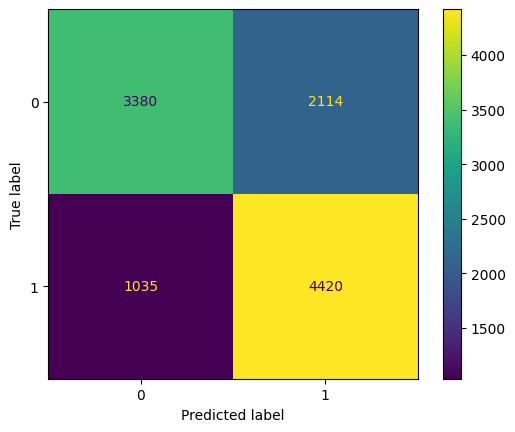

In [38]:
# test prediction confusion matrix

cm = confusion_matrix(y_test, ytest_tree_best_pred, labels=tree_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_best.classes_)
disp.plot()
plt.show()

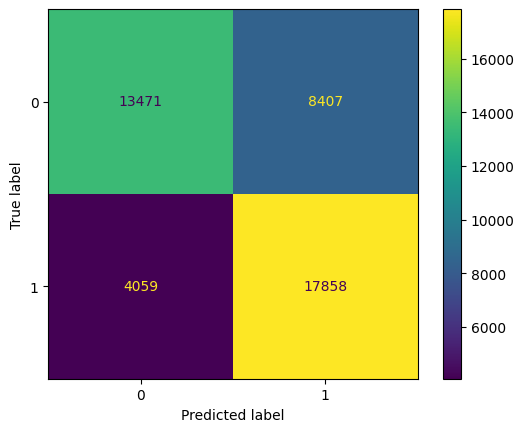

In [39]:
# train prediction confusion matrix

cm = confusion_matrix(y_train, ytrain_tree_best_pred, labels=tree_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_best.classes_)
disp.plot()
plt.show()

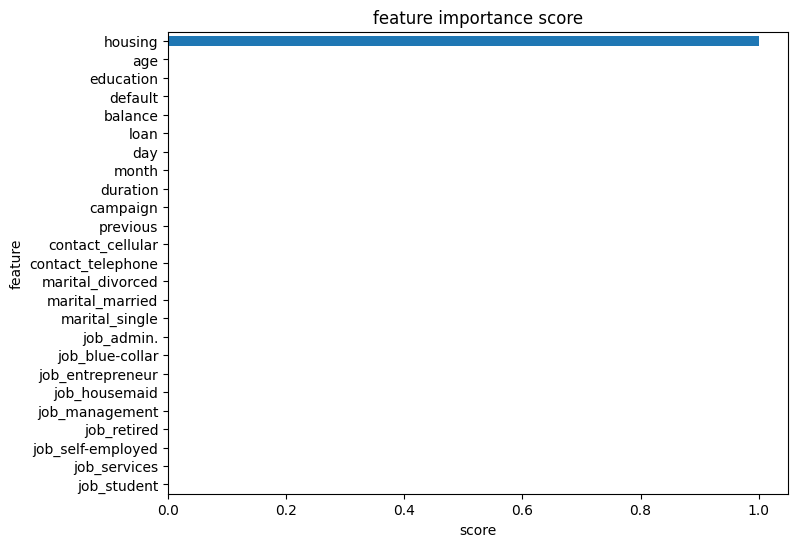

In [40]:
feat_importances = pd.Series(tree_best.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(8, 6))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')
plt.show()

### RandomForest

In [41]:
start_time = time.time()

forest = RandomForestClassifier(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                criterion='gini')
forest.fit(X_train, y_train)

print("\nExecution time: " + str((time.time() - start_time)) + ' ms')


Execution time: 3.817146062850952 ms


In [42]:
ytrain_forest_pred = forest.predict(X_train)
ytest_forest_pred  = forest.predict(X_test)

In [43]:
accuracy_forest_train = accuracy_score(y_train, ytrain_forest_pred)
accuracy_forest_test  = accuracy_score(y_test, ytest_forest_pred)
print("Accuracy  (Train Set)    : %.2f" % accuracy_forest_train)
print("Accuracy  (Test Set)     : %.2f" % accuracy_forest_test)

Accuracy  (Train Set)    : 1.00
Accuracy  (Test Set)     : 0.96


In [44]:
precision_forest_train = precision_score(y_train, ytrain_forest_pred)
precision_forest_test  = precision_score(y_test, ytest_forest_pred)
print("Precision  (Train Set)    : %.2f" % precision_forest_train)
print("Precision  (Test Set)     : %.2f" % precision_forest_test)

Precision  (Train Set)    : 1.00
Precision  (Test Set)     : 0.95


In [45]:
recall_forest_train = recall_score(y_train, ytrain_forest_pred)
recall_forest_test  = recall_score(y_test, ytest_forest_pred)
print("Precision  (Train Set)    : %.2f" % recall_forest_train)
print("Precision  (Test Set)     : %.2f" % recall_forest_test)

Precision  (Train Set)    : 1.00
Precision  (Test Set)     : 0.97


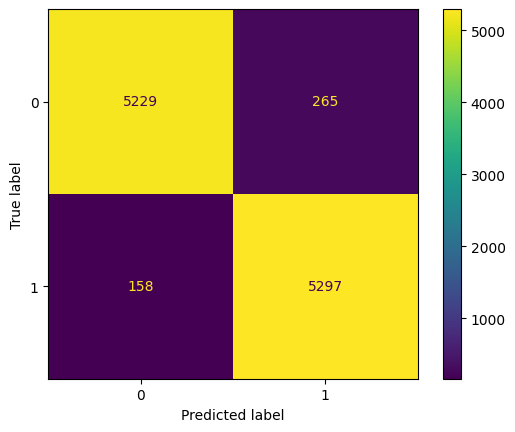

In [46]:
# test prediction confusion matrix

cm = confusion_matrix(y_test, ytest_forest_pred, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()
plt.show()

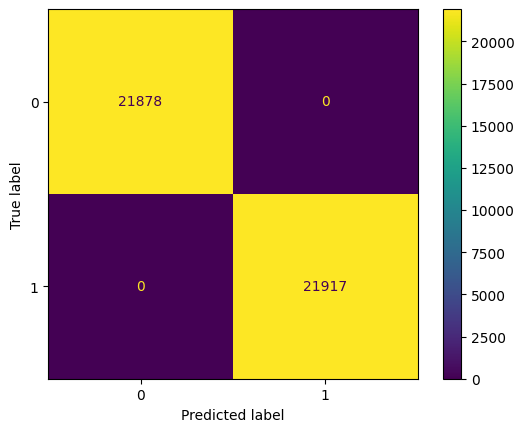

In [47]:
# train prediction confusion matrix

cm = confusion_matrix(y_train, ytrain_forest_pred, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()
plt.show()

#### With Hyperparameter Tuning

In [48]:
n_estimators = [50, 100, 200]
max_depth = [None, 5, 10]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [49]:
start_time = time.time()

random_forest = RandomForestClassifier()
forest_grid = GridSearchCV(random_forest, param_grid, cv=10)
forest_grid.fit(X_train, y_train)

print("Execution time: " + str((time.time() - start_time)) + ' ms')

Execution time: 251.6114146709442 ms


In [50]:
print("\nBest: %f using %s" % (forest_grid.best_score_, forest_grid.best_params_))


Best: 0.961434 using {'max_depth': None, 'n_estimators': 100}


In [51]:
ytrain_forest_grid_pred = forest_grid.predict(X_train)
ytest_forest_grid_pred  = forest_grid.predict(X_test)

In [52]:
accuracy_forest_grid_train = accuracy_score(y_train, ytrain_forest_grid_pred)
accuracy_forest_grid_test  = accuracy_score(y_test, ytest_forest_grid_pred)
print("Accuracy  (Train Set)    : %.2f" % accuracy_forest_train)
print("Accuracy  (Test Set)     : %.2f" % accuracy_forest_test)

Accuracy  (Train Set)    : 1.00
Accuracy  (Test Set)     : 0.96


In [53]:
precision_forest_grid_train = precision_score(y_train, ytrain_forest_grid_pred)
precision_forest_grid_test  = precision_score(y_test, ytest_forest_grid_pred)
print("Precision  (Train Set)    : %.2f" % precision_forest_train)
print("Precision  (Test Set)     : %.2f" % precision_forest_test)

Precision  (Train Set)    : 1.00
Precision  (Test Set)     : 0.95


In [54]:
recall_forest_grid_train = recall_score(y_train, ytrain_forest_grid_pred)
recall_forest_grid_test  = recall_score(y_test, ytest_forest_grid_pred)
print("Recall  (Train Set)    : %.2f" % recall_forest_grid_train)
print("Recall  (Test Set)     : %.2f" % recall_forest_grid_test)

Recall  (Train Set)    : 1.00
Recall  (Test Set)     : 0.97


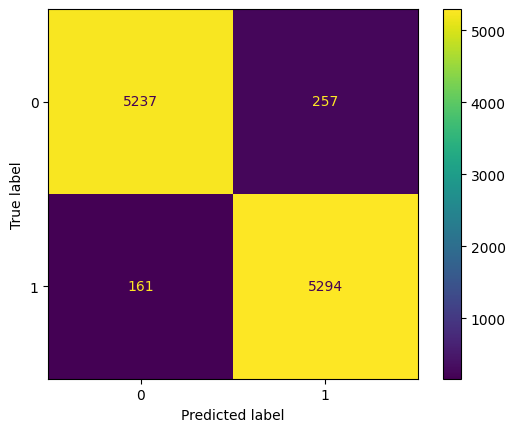

In [55]:
# test prediction confusion matrix

cm = confusion_matrix(y_test, ytest_forest_grid_pred, labels=forest_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_grid.classes_)
disp.plot()
plt.show()

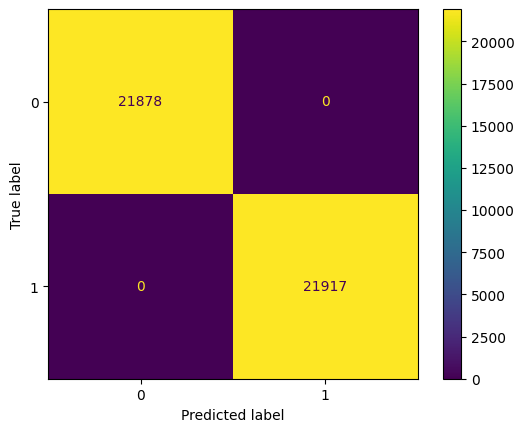

In [56]:
# train prediction confusion matrix

cm = confusion_matrix(y_train, ytrain_forest_grid_pred, labels=forest_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_grid.classes_)
disp.plot()
plt.show()

##### Phase 1 Learning Curve

param value: 1; train: 0.9624115823485727; test: 0.893469202466352
param value: 22; train: 0.9999994827947136; test: 0.9915539892364873
param value: 43; train: 0.9999999979144949; test: 0.9922616523249927
param value: 64; train: 1.0; test: 0.9930472606229545
param value: 85; train: 1.0; test: 0.993004600969577
param value: 106; train: 1.0; test: 0.993041921909978
param value: 127; train: 1.0; test: 0.9927784731080684
param value: 148; train: 1.0; test: 0.9932013158592808
param value: 169; train: 1.0; test: 0.9932168815443029
param value: 190; train: 1.0; test: 0.9932336484397445
param value: 211; train: 1.0; test: 0.9931575050459179
param value: 232; train: 1.0; test: 0.9931358498914072
param value: 253; train: 0.9999999999999999; test: 0.9932099579009115
param value: 274; train: 1.0; test: 0.9932860679277818
param value: 295; train: 1.0; test: 0.9931756733535159
param value: 316; train: 1.0; test: 0.9932529512238498
param value: 337; train: 1.0; test: 0.9933466289531084
param value: 3

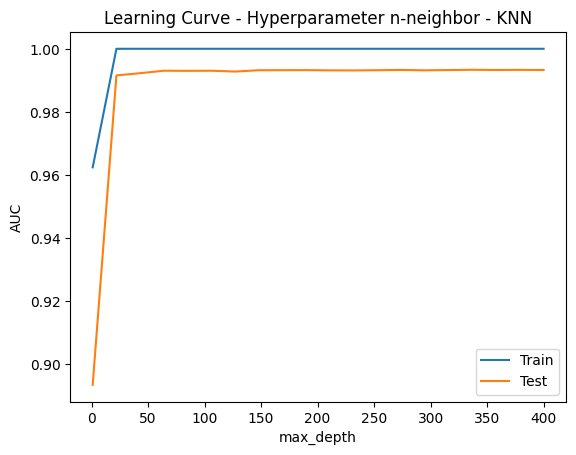

In [57]:
param_values = [int(x) for x in np.linspace(1, 400, 20)]
draw_learning_curve_forest(param_values)

#### Best Result Implementation From Learning Curve

In [58]:
start_time = time.time()

forest_best = RandomForestClassifier(max_depth=None,
                              criterion='gini',
                              n_estimators=242,
                              min_samples_split=2)
forest_best.fit(X_train, y_train)

print("\nExecution time: " + str((time.time() - start_time)) + ' ms')


Execution time: 9.326894760131836 ms


In [59]:
ytrain_forest_best_pred = forest_best.predict(X_train)
ytest_forest_best_pred  = forest_best.predict(X_test)

In [60]:
accuracy_forest_best_train = accuracy_score(y_train, ytrain_forest_best_pred)
accuracy_forest_best_test  = accuracy_score(y_test, ytest_forest_best_pred)
print("Accuracy  (Train Set)    : %.2f" % accuracy_forest_train)
print("Accuracy  (Test Set)     : %.2f" % accuracy_forest_test)

Accuracy  (Train Set)    : 1.00
Accuracy  (Test Set)     : 0.96


In [61]:
precision_forest_best_train = precision_score(y_train, ytrain_forest_best_pred)
precision_forest_best_test  = precision_score(y_test, ytest_forest_best_pred)
print("Precision  (Train Set)    : %.2f" % precision_forest_train)
print("Precision  (Test Set)     : %.2f" % precision_forest_test)

Precision  (Train Set)    : 1.00
Precision  (Test Set)     : 0.95


In [62]:
recall_forest_best_train = recall_score(y_train, ytrain_forest_best_pred)
recall_forest_best_test  = recall_score(y_test, ytest_forest_best_pred)
print("Recall  (Train Set)    : %.2f" % recall_forest_best_train)
print("Recall  (Test Set)     : %.2f" % recall_forest_best_test)

Recall  (Train Set)    : 1.00
Recall  (Test Set)     : 0.97


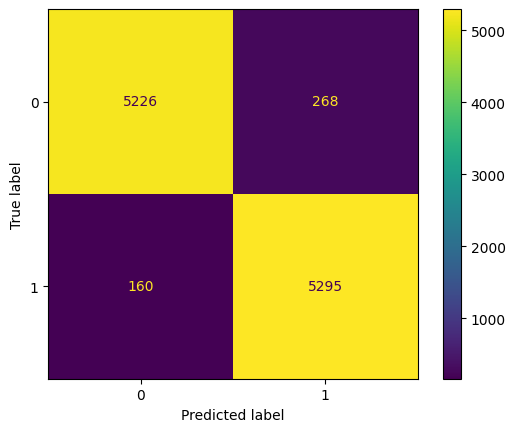

In [63]:
# test prediction confusion matrix

cm = confusion_matrix(y_test, ytest_forest_best_pred, labels=forest_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_best.classes_)
disp.plot()
plt.show()

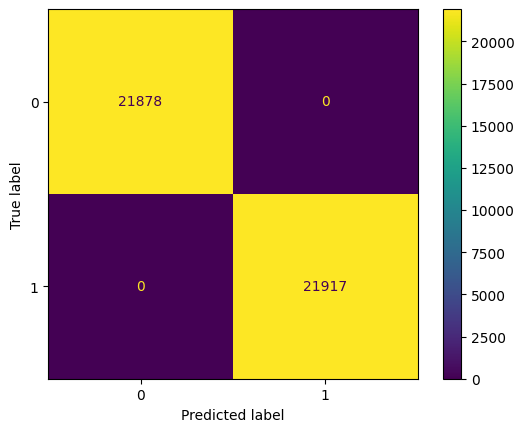

In [64]:
# train prediction confusion matrix

cm = confusion_matrix(y_train, ytrain_forest_best_pred, labels=forest_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_best.classes_)
disp.plot()
plt.show()

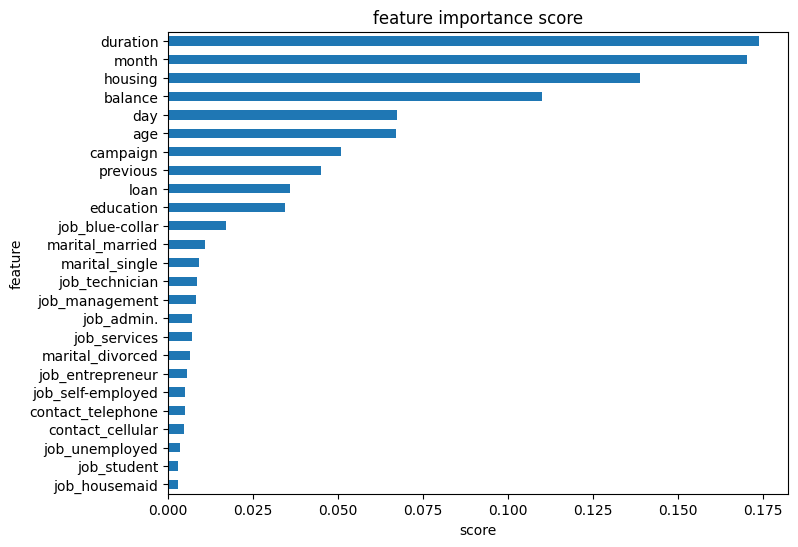

In [65]:
feat_importances = pd.Series(forest_best.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(8, 6))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')
plt.show()

In [66]:
X_test.columns.to_list()

['age',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'month',
 'duration',
 'campaign',
 'previous',
 'contact_cellular',
 'contact_telephone',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed']

In [68]:
# visalualize tree

iris = load_iris()
iris.target = y_test
iris.data = X_test
iris.feature_names = X_test.columns.to_list()
iris.target_names = ['yes','no']

# Model (can also use single decision tree)

# Train
forest.fit(iris.data, iris.target)
# Extract single tree
estimator = forest.estimators_[1]

export = os.getcwd()
export_forest = export+'/stage-3/second-iteration/output/tree.dot'

# Export as dot file
export_graphviz(estimator, out_file=export_forest, 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [72]:
export_tree = export+'/stage-3/second-iteration/output/decision_tree.dot'

export_graphviz(tree_best, out_file=export_tree, 
                feature_names=iris.feature_names,  
                class_names=iris.target_names,
                filled=True)